# <font color='red'> Model-2 </font>

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Fit TF-IDF vectorizer on the Train data <br>
2. Get the idf value for each word we have in the train data. Please go through <a  href='https://stackoverflow.com/questions/23792781/tf-idf-feature-weights-using-sklearn-feature-extraction-text-tfidfvectorizer'>this</a><br>

3. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very 
frequent words and very very rare words don't give much information.
Hint - A preferable IDF range is 2-11 for model 2. <br>
4.Remove the low idf value and high idf value words from the train and test data. You can go through each of the
sentence of train and test data and include only those features(words) which are present in the defined IDF range.
5. Perform tokenization on the modified text data same as you have done for previous model.
6. Create embedding matrix for model 2 and then use the rest of the features similar to previous model.
7. Define the model, compile and fit the model.
</pre>

In [1]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Input , Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
import tensorflow as tf
from sklearn.metrics import roc_auc_score
from tensorflow.keras.metrics import AUC

from sklearn import preprocessing
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from scipy.sparse import coo_matrix, hstack
from scipy.sparse import csr_matrix
from numpy import asarray
from numpy import zeros


from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

In [2]:
#read the csv file

p1 = '/content/drive/MyDrive/AAIC/Assignments/LSTM on Donors Choose/preprocessed_data_final.csv'
p2 = "C:/Users/darsh/Downloads/Srujan/Donars Choose Assignment/preprocessed_data_final.csv"
df_2 = pd.read_csv(p2)

In [3]:
text_input = ['essay','project_title','project_resource_summary',]
df_2['total_text_input'] = df_2['essay'] + ' ' + df_2['project_title'] + ' ' + df_2['project_resource_summary']



In [4]:

corpus = df_2['total_text_input']
vectorizer = TfidfVectorizer(min_df=15)
X = vectorizer.fit_transform(corpus)
idf = vectorizer.idf_
idf_values = (dict(zip(vectorizer.get_feature_names_out(), idf)))

In [5]:
word_features = pd.DataFrame(idf_values.items(),columns=['word_features','idf_values']).sort_values(['idf_values'])

<AxesSubplot: xlabel='idf_values'>

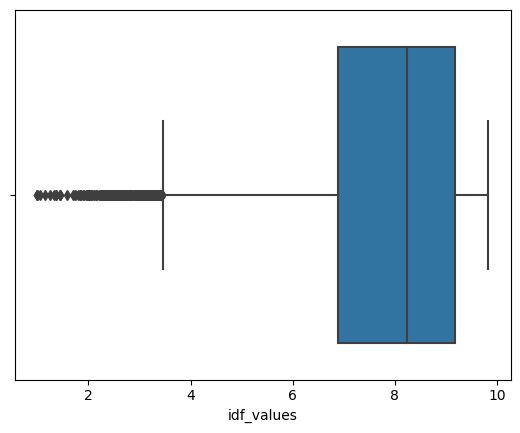

In [6]:
sns.boxplot(x=word_features['idf_values'],)

<AxesSubplot: >

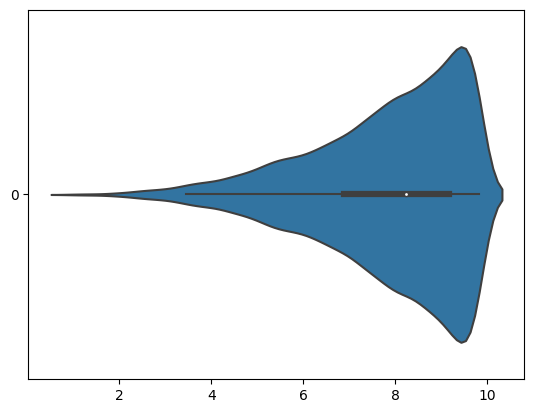

In [7]:
sns.violinplot(word_features['idf_values'],orient='h')

In [8]:
percentiles = np.percentile(word_features['idf_values'],np.arange(0,100))[[0,25,75,90]]
percentiles

array([1.        , 6.88025485, 9.16739776, 9.60565269])

In [9]:
word_features = word_features[(word_features.idf_values >= percentiles[1]) & (word_features.idf_values <= percentiles[2])]

In [10]:
feats = list(word_features['word_features'].values)

In [11]:
dummy_words = set(vectorizer.get_feature_names()).difference(set(feats))

In [12]:
final_text = dict()
df_2['text_data_for_model_2'] = ""
for indx in tqdm(df_2['total_text_input'].index):
    temp_list = list()
    for j in df_2['total_text_input'][indx].split():
        if j not in dummy_words:
            temp_list.append(j)
    final_text[indx] = " ".join(temp_list)
    df_2['text_data_for_model_2'].loc[indx] = " ".join(temp_list)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 109248/109248 [00:22<00:00, 4912.87it/s]


In [13]:
 df_2[pd.isnull(df_2).any(axis=1)]

,teacher_number_of_previously_posted_projects,resource_summary_contains_numerical_digits,price,quantity,school_state,project_grade_category,clean_categories,clean_subcategories,teacher_prefix,project_is_approved,essay,project_title,project_resource_summary,total_text_input,text_data_for_model_2


In [14]:
y = df_2['project_is_approved'].values
df_2.drop(['project_is_approved'],axis=1,inplace=True)
X_train, X_test, y_train, y_test = train_test_split(df_2, y,
                                                    stratify=y, 
                                                    test_size=0.10,
                                                   )

In [15]:
num_words = 1000
oov_token = '<UNK>'
pad_type = 'post'
trunc_type = 'post'

# Tokenize our training data
tokenizer = Tokenizer(num_words=num_words, oov_token=oov_token)
tokenizer.fit_on_texts(X_train['text_data_for_model_2'])

# Get our training data word index
word_index = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences = tokenizer.texts_to_sequences(X_train['text_data_for_model_2'])
test_sequences = tokenizer.texts_to_sequences(X_test['text_data_for_model_2'])

# Get max training sequence length
maxlen = max([len(x) for x in train_sequences])

# Pad the training sequences
train_padded = pad_sequences(train_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)
test_padded = pad_sequences(test_sequences, padding=pad_type, truncating=trunc_type, maxlen=maxlen)

In [16]:
maxlen

122

In [17]:
# Output the results of our work
#print("Word index:\n", word_index)
#print("\nTraining sequences:\n", train_sequences)
#print("\nPadded training sequences:\n", train_padded)
print("\nPadded training shape, Test Shape:", train_padded.shape,test_padded.shape)
print("Training sequences data type:", type(train_sequences),type(test_sequences))
print("Padded Training sequences data type:", type(train_padded),type(test_padded))



Padded training shape, Test Shape: (98323, 122) (10925, 122)
Training sequences data type: <class 'list'> <class 'list'>
Padded Training sequences data type: <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [18]:
from tqdm import tqdm

# load the whole embedding into memory
embeddings_index = dict()
p1 = '/content/drive/MyDrive/AAIC/Assignments/LSTM on Donors Choose/glove.6B.300d.txt'
p2 = "C:/Users/darsh/Downloads/Srujan/Donars Choose Assignment/glove.6B.300d.txt"
f = open(p2,encoding="utf8")
for line in tqdm(f):
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('\nLoaded %s word vectors.' % len(embeddings_index))

400000it [00:21, 18381.50it/s]


Loaded 400000 word vectors.


In [19]:
vocab_size = len(tokenizer.word_index) + 1

In [20]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# <font color='blue'> Categorical feature Vectorization </font>

In [21]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)

In [22]:
school_state_enc = (enc.fit_transform(np.array(X_train['school_state']).reshape(-1,1)))
teacher_prefix_enc = (enc.fit_transform(np.array(X_train['teacher_prefix']).reshape(-1,1)))
project_grade_category_enc = (enc.fit_transform(np.array(X_train['project_grade_category']).reshape(-1,1)))
clean_categories_enc = (enc.fit_transform(np.array(X_train['clean_categories']).reshape(-1,1)))
clean_subcategories_enc = (enc.fit_transform(np.array(X_train['clean_subcategories']).reshape(-1,1)))


In [23]:
school_state_enc_test = (enc.transform(np.array(X_test['school_state']).reshape(-1,1)))
teacher_prefix_enc_test = (enc.transform(np.array(X_test['teacher_prefix']).reshape(-1,1)))
project_grade_category_enc_test = (enc.transform(np.array(X_test['project_grade_category']).reshape(-1,1)))
clean_categories_enc_test = (enc.transform(np.array(X_test['clean_categories']).reshape(-1,1)))
clean_subcategories_enc_test = (enc.transform(np.array(X_test['clean_subcategories']).reshape(-1,1)))


 # <font color='blue'>Numerical Feature Vectorization </font>

In [24]:
numerical_input = ['teacher_number_of_previously_posted_projects',
                   'resource_summary_contains_numerical_digits',
                   'price','quantity'
                  ]

scaler  = preprocessing.StandardScaler().fit(X_train[numerical_input])
std_data_train = np.array(pd.DataFrame(scaler.transform(X_train[numerical_input]),columns=numerical_input))
std_data_test = np.array(pd.DataFrame(scaler.transform(X_test[numerical_input]),columns=numerical_input))

# <font color='blue'>defining the model</font>

In [25]:
elements_in_school_state = (len(set(pd.DataFrame(school_state_enc)[0])))
elements_in_teacher_prefix = (len(set(pd.DataFrame(teacher_prefix_enc)[0])))
elements_in_project_grade_category = (len(set(pd.DataFrame(project_grade_category_enc)[0])))
elements_in_clean_categories = (len(set(pd.DataFrame(clean_categories_enc)[0])))
elements_in_clean_subcategories = (len(set(pd.DataFrame(clean_subcategories_enc)[0])))

In [26]:
input_seq_total_text_data = Input(shape=(maxlen,),name='input_seq_total_text_data_')
emb_text_data = Embedding(input_dim=vocab_size,output_dim=300, 
                          weights=[embedding_matrix], input_length=maxlen,trainable=False,
                          name='emb_text_data')(input_seq_total_text_data)
lstm = LSTM(units=25,activation='tanh',return_sequences=True)(emb_text_data)
flatten_text = Flatten()(lstm)

input_school_state = Input(shape=1,name='input_school_state')
input_school_state_emb = Embedding(input_dim=elements_in_school_state,
                                   output_dim=int(min(elements_in_school_state / 2, 50)),
                                   input_length=1,
                                  name='input_school_state_emb')(input_school_state)
flatten_school_state = Flatten()(input_school_state_emb)


input_grade_category = Input(shape=1,name='input_grade_category')
input_grade_category_emb = Embedding(input_dim=elements_in_project_grade_category,
                                   output_dim=int(min(elements_in_project_grade_category / 2, 50)),
                                   input_length=1,
                                  name='input_grade_category_emb')(input_grade_category)
flatten_grade_category = Flatten()(input_grade_category_emb)


input_clean_categories = Input(shape=1,name='input_clean_categories')
input_clean_categories_emb = Embedding(input_dim=elements_in_clean_categories,
                                      output_dim=int(min(elements_in_clean_categories / 2, 50)),
                                      input_length=1,
                                      name='input_clean_categories_emb')(input_clean_categories)
flatten_clean_categories = Flatten()(input_clean_categories_emb)



input_clean_sub_categories = Input(shape=1,name='input_clean_sub_categories')
input_clean_sub_categories_emb = Embedding(input_dim=elements_in_clean_subcategories,
                                      output_dim=int(min(elements_in_clean_subcategories / 2, 50)),
                                      input_length=1,
                                      name='input_clean_sub_categories_emb')(input_clean_sub_categories)
flatten_clean_sub_categories = Flatten()(input_clean_sub_categories_emb)


input_teacher_prefix = Input(shape=1,name='input_teacher_prefix')
input_teacher_prefix_emb = Embedding(input_dim=elements_in_teacher_prefix,
                                      output_dim=int(min(elements_in_teacher_prefix / 2, 50)),
                                      input_length=1,
                                      name='input_teacher_prefix_emb')(input_teacher_prefix)
flatten_teacher_prefix = Flatten()(input_teacher_prefix_emb)



input_remaining = Input(shape=4,name='input_remaining')
input_remaining_dense = Dense(units=128,activation='relu',
                               kernel_initializer='he_normal',kernel_regularizer=l2(0.00001),
                              name='input_remaining_dense')(input_remaining)
flatten_remaining = Flatten()(input_remaining_dense)

concat_layer = concatenate([flatten_text,flatten_school_state,flatten_grade_category,
                            flatten_clean_categories,flatten_clean_sub_categories,
                            flatten_teacher_prefix,flatten_remaining],)

dense_layer1_after_concat = Dense(units=128,activation='relu',
                                  kernel_initializer='he_normal',kernel_regularizer=l2(0.00001),
                                  name='dense_layer1_after_concat')(concat_layer)
drop1 = Dropout(0.5)(dense_layer1_after_concat)

dense_layer2_after_concat = Dense(units=128,activation='relu',
                                  kernel_initializer='he_normal',kernel_regularizer=l2(0.00001),
                                  name='dense_layer2_after_concat')(drop1)
drop2 = Dropout(0.5)(dense_layer2_after_concat)

bn1 = BatchNormalization()(drop2)

dense_layer3_after_concat = Dense(units=128,activation='relu',
                                  kernel_initializer='he_normal',kernel_regularizer=l2(0.00001),
                                  name='dense_layer3_after_concat')(bn1)
drop3 = Dropout(0.5)(dense_layer3_after_concat)

dense_layer4_after_concat = Dense(units=128,activation='relu',
                                  kernel_initializer='he_normal',kernel_regularizer=l2(0.00001),
                                  name='dense_layer4_after_concat')(drop3)
drop4 = Dropout(0.5)(dense_layer4_after_concat)

output = Dense(units=2,activation='softmax')(drop4)


In [27]:
m2 = Model(inputs=[input_seq_total_text_data, 
                   input_school_state,
                   input_grade_category,
                   input_clean_categories,
                   input_clean_sub_categories,
                   input_teacher_prefix,
                   input_remaining],
           outputs=[output])

In [28]:
m2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_seq_total_text_data_ (Inp [(None, 122)]        0                                            
__________________________________________________________________________________________________
emb_text_data (Embedding)       (None, 122, 300)     17916300    input_seq_total_text_data_[0][0] 
__________________________________________________________________________________________________
input_school_state (InputLayer) [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_grade_category (InputLaye [(None, 1)]          0                                            
______________________________________________________________________________________________

In [29]:
test_data = [test_padded,school_state_enc_test,project_grade_category_enc_test,
            clean_categories_enc_test,clean_subcategories_enc_test,teacher_prefix_enc_test,(std_data_test)]

train_data = [train_padded,school_state_enc,project_grade_category_enc,
              clean_categories_enc,clean_subcategories_enc,teacher_prefix_enc,(std_data_train)]             

y_train_enc =  tensorflow.keras.utils.to_categorical(y_train, 2)
y_test_enc =  tensorflow.keras.utils.to_categorical(y_test, 2)

In [30]:
def auc1(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score( y_true, y_pred, average='macro', sample_weight=None).astype('double')

def auroc(y_true, y_pred):
    return tensorflow.numpy_function(auc1, (y_true, y_pred), tensorflow.double)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./LSTM_Model_2.h5', save_weights_only=False,save_best_only=True, \
                                       mode='max', monitor='val_auroc',verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auroc', patience=2,mode='max',verbose=1,min_lr=0.00001),
]



In [31]:
m2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[auroc])

In [32]:
m2.fit(train_data,y_train_enc,
       validation_data=(test_data,y_test_enc),
       batch_size=128,
       epochs=50,
       callbacks=callbacks,
       verbose=1)

Epoch 1/50
769/769 [==============================] - 22s 20ms/step - loss: 0.4851 - auroc: 0.5610 - val_loss: 0.4843 - val_auroc: 0.6053

Epoch 00001: val_auroc improved from -inf to 0.60534, saving model to .\LSTM_Model_2.h5
Epoch 2/50
769/769 [==============================] - 14s 18ms/step - loss: 0.4279 - auroc: 0.6325 - val_loss: 0.4552 - val_auroc: 0.6596

Epoch 00002: val_auroc improved from 0.60534 to 0.65958, saving model to .\LSTM_Model_2.h5
Epoch 3/50
769/769 [==============================] - 14s 18ms/step - loss: 0.4187 - auroc: 0.6636 - val_loss: 0.4376 - val_auroc: 0.6794

Epoch 00003: val_auroc improved from 0.65958 to 0.67940, saving model to .\LSTM_Model_2.h5
Epoch 4/50
769/769 [==============================] - 14s 18ms/step - loss: 0.4131 - auroc: 0.6794 - val_loss: 0.4381 - val_auroc: 0.6842

Epoch 00004: val_auroc improved from 0.67940 to 0.68418, saving model to .\LSTM_Model_2.h5
Epoch 5/50
769/769 [==============================] - 14s 18ms/step - loss: 0.4088 

769/769 [==============================] - 14s 18ms/step - loss: 0.3760 - auroc: 0.7649 - val_loss: 0.4122 - val_auroc: 0.6800

Epoch 00041: val_auroc did not improve from 0.69386
Epoch 42/50
769/769 [==============================] - 14s 18ms/step - loss: 0.3760 - auroc: 0.7656 - val_loss: 0.4123 - val_auroc: 0.6800

Epoch 00042: val_auroc did not improve from 0.69386
Epoch 43/50
769/769 [==============================] - 14s 18ms/step - loss: 0.3757 - auroc: 0.7649 - val_loss: 0.4121 - val_auroc: 0.6800

Epoch 00043: val_auroc did not improve from 0.69386
Epoch 44/50
769/769 [==============================] - 14s 18ms/step - loss: 0.3756 - auroc: 0.7652 - val_loss: 0.4123 - val_auroc: 0.6797

Epoch 00044: val_auroc did not improve from 0.69386
Epoch 45/50
769/769 [==============================] - 14s 18ms/step - loss: 0.3749 - auroc: 0.7668 - val_loss: 0.4121 - val_auroc: 0.6796

Epoch 00045: val_auroc did not improve from 0.69386
Epoch 46/50
769/769 [==============================]